<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/PINN_method_for_1D_Burgers'_equation_forward_problem_using_L_BFGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on method presented in:  
*Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*  
https://www.sciencedirect.com/science/article/pii/S0021999118307125?casa_token=IF_2eTCwVfkAAAAA:-AYLqjAlpXcFYBHje4sO2kMjqH3k0pdFQ7Qdpw1MazWxIGPwacb3Cp0gCtFRbNDAVLSsjCWU0g

## Setup

In [1]:
# install devito
!pip install devito &> /dev/null

In [2]:
# import required libraries and tools
import numpy as np
from numpy.random import default_rng
rng = default_rng()

from time import perf_counter

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

import torch
from torch import nn

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

import sys
!git clone https://github.com/StephenTGibson/MScDataSci_21-22.git &> /dev/null
sys.path.append('/content/MScDataSci_21-22/COMP702-MScProject')
import utilityFunctions
import physicsInformedNeuralNetworks

## Finite difference solver

In [3]:
# solves 1D Burgers' equations using devito finite difference computation
def devitoSolver_1D_Burgers(tResolution, xResolution, tMin, tMax, xMin, xMax, l1, l2):
    # define discretisation
    # extent x direction
    extent_x = xMax - xMin
    # number of x grid points
    nx = xResolution
    # x direction step size
    dx = extent_x / (nx - 1)
    # time extent (total duration)
    T = tMax - tMin
    # time step
    dt = 1e-4
    # number of time points
    nt = int(T / dt)

    # create 1D grid and assign dimension variable names
    grid = Grid(shape=(nx), extent=(extent_x))
    x = grid.dimensions
    t = grid.stepping_dim
    # create time function on grid
    # space order of 2 to enable 2nd derivative
    u = TimeFunction(name='u', grid=grid, space_order=2)
    # create constant (viscosity)
    a = Constant(name='a')
    b = Constant(name='b')
    # define 1D Burgers' equation
    equation_u = Eq(u.dt + a*u*u.dxl, b*u.dx2)
    # create stencil by solving for next time step
    stencil_u = solve(equation_u, u.forward)
    # define equation for next time step
    update_u = Eq(u.forward, stencil_u)
    # define boundary conditions
    # u = 0 at min and max extent of x
    boundaryConditions = [Eq(u[t+1, 0], 0.)]
    boundaryConditions += [Eq(u[t+1, nx], 0.)]
    # define operator based on equation and boundary conditions
    op = Operator([update_u] + boundaryConditions)

    # set solution space to 0s
    u.data[:] = 0
    # create a dummy x array from -1 to +1
    dummyX = np.arange(-1, 1+dx, dx)
    # set initial conditions using dummy x array
    u.data[0] = -1 * np.sin(np.pi * dummyX)

    # define number of time steps to compute before storing result
    batchSize = int(nt/tResolution)

    # initialise empty array to store computed solution
    results = np.zeros((nx, tResolution))
    # store initial conditions in results array
    results[:,0] = u.data[0].copy()

    # log start time to measure performance
    startTime = perf_counter()

    # iterate over result steps
    # start from 1 not 0 as results at step 0 are the initial conditions
    for timeStep in range(1, tResolution):
        # compute solution after batchSize time steps
        summary = op.apply(time=batchSize, dt=dt, a=l1, b=l2)
        # store computed solution in results array
        results[:,timeStep] = u.data[0].copy()

    # record computation time
    duration = perf_counter()-startTime

    return results, duration

## Data generator

In [8]:
# number of points initial condition and boundary points
# proportion of Nu which are initial condition points
# number of collocation points across input domain interior    
def dataGenerator_1D_BurgersForward(Nu, propNu_ic, Ninterior, xMin, xMax, tMin, tMax):
    # number of initial condition points
    Nu_i = int(propNu_ic * Nu)
    # number of boundary condition points
    Nu_bc = Nu - Nu_i
    # total number collocation points
    Nf = Ninterior + Nu
    # uniformly randomly select some points along the x axis to generate initial condition training points
    uniformRandomXArray = rng.uniform(low=xMin, high=xMax, size=Nu_i)
    # create array of initial condition defined training points
    # t = 0
    # x = uniformly random from x domain
    # u = -1*sin(pi*x)
    Nu_iArray= np.array([
                    np.zeros(Nu_i),
                    uniformRandomXArray,
                    -1 * np.sin(np.pi * uniformRandomXArray)
                        ]).T
    # uniformly randomly select some points along the time axis to generate boundary condition training points
    # t = uniformly random from time domain
    # x = random choice of -1 or 1
    # u = 0
    Nu_bcArray = np.array([
                            rng.uniform(low=tMin, high=tMax, size=Nu_bc),
                            rng.choice(np.array([-1,1]), size=Nu_bc, replace=True),
                            np.zeros(Nu_bc)
                            ]).T
    # concatenate initial and boundary condition points to create complete Nu training points array
    NuArray = np.concatenate([Nu_iArray, Nu_bcArray])
    # create collocation training points selected uniformly randomly across input domain
    NinteriorArray = np.array([
                rng.uniform(tMin, tMax, Ninterior),
                rng.uniform(xMin, xMax, Ninterior),
                ]).T
    # concatenate randomly selected interior points with NuArray points (excluding solution values) to create Nf training points array
    NfArray = np.concatenate([NinteriorArray, NuArray[:,:-1]])
    return NuArray, NfArray

## Create training data

In [39]:
# define spatial and temporal domain extent
xMin = -1
xMax = 1
tMin = 0
tMax = 1

NuArray, NfArray = dataGenerator_1D_BurgersForward(40, 0.6, 2000, xMin, xMax, tMin, tMax)

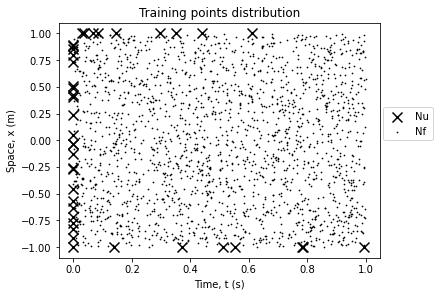

In [40]:
fig, ax  = plt.subplots(figsize=(6, 4), constrained_layout=True)

ax.scatter(NuArray[:,0],
           NuArray[:,1],
           s=100.,
           c='k',
           marker='x',
           label='Nu',
           )
ax.scatter(NfArray[:,0],
           NfArray[:,1],
           s=2.,
           c='k',
           marker='.',
           label='Nf',
           )

ax.set_title('Training points distribution')
ax.set_xlabel('Time, t (s)')
ax.set_ylabel('Space, x (m)')
ax.legend(loc=(1.01, 0.5))
plt.show()

## Define PINN

In [43]:
# define network characteristics
hiddenLayers = 9
nodesPerLayer = 20
activationFunction = nn.Tanh()
maxIterations = 2000
maxEvaluations = 2000
l1 = 1.
l2 = 0.01/np.pi
inverseProblem = False

# create network and print number of trainable parameters
model = physicsInformedNeuralNetworks.PINN_1D_Burgers(hiddenLayers, nodesPerLayer, activationFunction, maxIterations, maxEvaluations, l1, l2, inverseProblem)
print(f'Network parameters: {sum(p.numel() for p in model.parameters())}')

Network parameters: 3861


## Perform training

Epoch: 1 --- Elapsed time: 0.04s --- Loss: 0.35364463925361633
Epoch: 2 --- Elapsed time: 0.10s --- Loss: 0.3069414496421814
Epoch: 4 --- Elapsed time: 0.19s --- Loss: 0.2776121199131012
Epoch: 8 --- Elapsed time: 0.39s --- Loss: 0.27690139412879944
Epoch: 16 --- Elapsed time: 0.77s --- Loss: 0.24406194686889648
Epoch: 32 --- Elapsed time: 1.54s --- Loss: 0.18724243342876434
Epoch: 64 --- Elapsed time: 3.13s --- Loss: 0.1272110939025879
Epoch: 128 --- Elapsed time: 6.23s --- Loss: 0.09294716268777847
Epoch: 256 --- Elapsed time: 12.70s --- Loss: 0.04182517156004906
Epoch: 500 --- Elapsed time: 25.06s --- Loss: 0.016680918633937836
Epoch: 1000 --- Elapsed time: 50.99s --- Loss: 0.007372737862169743
Epoch: 1500 --- Elapsed time: 76.75s --- Loss: 0.003967088647186756
Epoch: 2000 --- Elapsed time: 102.27s --- Loss: 0.002952761249616742


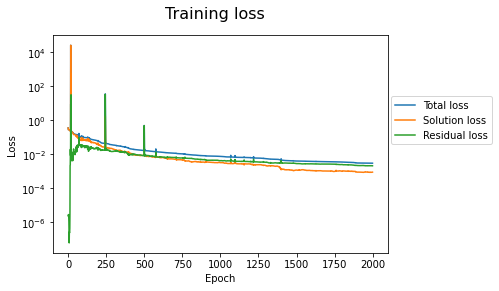

In [44]:
# train model
model.trainer(NuArray, NfArray)
# plot training loss curves
utilityFunctions.trainingHistoryPlot(model.history, ['Total loss', 'Solution loss', 'Residual loss'], 'Loss', 'Training loss', yLogAx=True)
plt.show()

## Generate solution

In [45]:
# compute meshgrid, solution and residual
# arguments: (model, xDim, yDim, xMin, xMax, yMin, yMax, xArg, yArg, residual=True)
mesh_x, mesh_y, PINN_solution, PINN_residual = utilityFunctions.create2dMeshData_1dBurgers(model, 1000, 600, 0, 1, -1, 1, 't', 'x', residual=True)

## Results

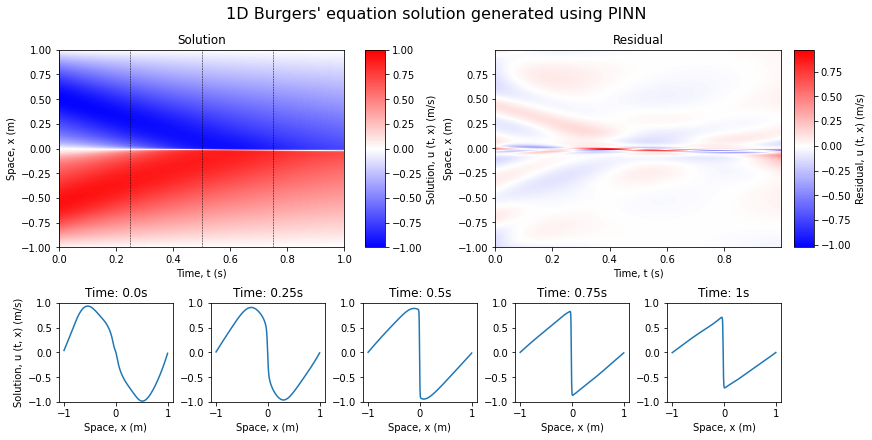

In [46]:
# create figure using gridspec to structure subplots
fig = plt.figure(
    figsize=(12, 6),
    constrained_layout=True
    )
gs = GridSpec(3, 20, figure=fig)

# add solution plot
solutionAx = fig.add_subplot(gs[:2,:10])
solutionPlot = solutionAx.pcolormesh(mesh_x, mesh_y, PINN_solution, cmap='bwr', vmin=-1, vmax=1)
solutionAx.set_xlim([0, 1])
solutionAx.set_ylim([-1, 1])

solutionAx.set_title('Solution')
solutionAx.set_xlabel('Time, t (s)')
solutionAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(solutionPlot, use_gridspec=True)
cbar.set_label('Solution, u (t, x) (m/s)')

# add residual plot
residualAx = fig.add_subplot(gs[:2,10:])
norm = TwoSlopeNorm(vcenter=0)
residualPlot = residualAx.pcolormesh(mesh_x, mesh_y, PINN_residual, cmap='bwr', norm=norm)
residualAx.set_title('Residual')
residualAx.set_xlabel('Time, t (s)')
residualAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(residualPlot, use_gridspec=True)
cbar.set_label('Residual, u (t, x) (m/s)')

# iteratively create solution snapshot subplots
for i in range(5):
    tPlot = fig.add_subplot(gs[2, i*4:(i+1)*4])    
    if i < 4:
        tPlot.plot(mesh_y[:, i*(mesh_y.shape[1]//4)], PINN_solution[:, i*(mesh_y.shape[1]//4)])
        tPlot.set_title('Time: ' + str(i*mesh_x[0, mesh_x[0].shape[0]//4]) + 's')
        # add vertical lines to solution plot to indicate snapshots
        solutionAx.vlines(x=i*mesh_x[0, mesh_x[0].shape[0]//4], ymin=mesh_y[0,0], ymax=mesh_y[-1,0], colors='black', ls='--', lw=0.5)
    else:
        tPlot.plot(mesh_y[:, -1], PINN_solution[:, -1])
        tPlot.set_title('Time: ' + str(tMax) + 's')
    
    tPlot.set_ylim([-1, 1])
    tPlot.set_xlabel('Space, x (m)')
    if i == 0:
        tPlot.set_ylabel('Solution, u (t, x) (m/s)')

# figure title
fig.suptitle("1D Burgers' equation solution generated using PINN", fontsize=16)

# fig.savefig("1D Burgers' solution - PINN", bbox_inches='tight')
plt.show()

In [ ]:
FD_solution, FD_duration = devitoSolver_1D_Burgers(1000, 600, tMin, tMax, xMin, xMax, l1, l2)

In [48]:
print(FD_solution.shape)
print(PINN_solution.shape)

(600, 1000)
(600, 1000)


In [49]:
np.linalg.norm(FD_solution-PINN_solution, 2) / np.linalg.norm(FD_solution, 2)

0.06639565188576595

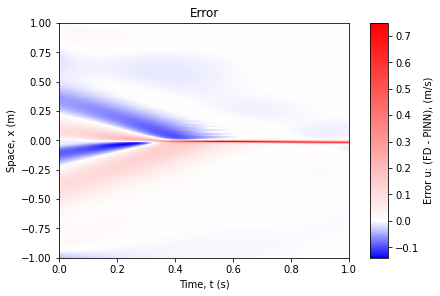

In [50]:
fig = plt.figure(
    figsize=(6, 4),
    constrained_layout=True
    )
gs = GridSpec(1, 1, figure=fig)
norm = TwoSlopeNorm(vcenter=0)

errorAx = fig.add_subplot(gs[:,:])
errorPlot = errorAx.pcolormesh(mesh_x, mesh_y, FD_solution - PINN_solution, cmap='bwr', norm=norm)

errorAx.set_xlim([0, 1])
errorAx.set_ylim([-1, 1])

errorAx.set_title('Error')
errorAx.set_xlabel('Time, t (s)')
errorAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(errorPlot, use_gridspec=True)
cbar.set_label('Error u: (FD - PINN), (m/s)')